In [59]:
# as you go through this code, the only thing you'll need to change is the file name of the video to be analyzed

# import libraries

import numpy as np
import cv2
import trackpy as tp
import matplotlib.pyplot as plt
import pandas as pd
import os

In [269]:
# run necessary functions

def contour_on_border(c,width,height):
    xmin = 1
    ymin = 1
    xmax = width
    ymax = height
    
    x,y,w,h = cv2.boundingRect(c)
    return (x <= xmin or y <= ymin or w >= xmax or h >= ymax)

def get_copepod_location(frame,thresh_level):
    width = np.shape(frame)[1]
    height = np.shape(frame)[0]

    imgray = cv2.equalizeHist(frame) 
    blur = cv2.GaussianBlur(imgray,(9,9),0)
    ret, thresh = cv2.threshold(blur, 50, 255, 0)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    areas = [cv2.contourArea(c) * (not contour_on_border(c,width,height)) for c in contours]
    
    # copepod is assumed to be the largest contour that IS NOT touching the border. this could fail if there are two copepods
    copepod_contour = np.argmax(areas)
    M = cv2.moments(contours[copepod_contour])
    
    cX_raw = M["m10"] / M["m00"]
    cY_raw = M["m01"] / M["m00"]
    
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return (cX_raw, cY_raw, cX,cY,imgray,thresh)

# crops frame to a square; tries to handle the case where the square goes outside the frame
def crop_frame(frame,cX,cY,s2):
    cX = int(cX)
    cY = int(cY)
    width = np.shape(frame)[1]
    height = np.shape(frame)[0]
    
    cropped = np.zeros((2*s2,2*s2))
    
    y = cY - s2
    h = cY + s2
    
    if y < 0:
        y = 0
    if h >= height - 1:
        h = height - 1
    
    x = cX - s2
    w = cX + s2
    
    if x < 0:
        x = 0
    if w >= width - 1:
        w = width - 1
    
    cropped[y - cY + s2 : h - cY + s2, x - cX + s2 : w - cX + s2] = frame[y : h, x : w]
    return cropped
    

In [273]:
# here is where video-specific code starts
# set working directory based on video to be analyzed

## FILE TO BE ANALYZED -- IN PRINCIPLE THIS IS ALL THAT NEEDS TO BE CHANGED
## then one just has to go to Kernel at the top and then click 'Restart and Run All'

# name of video file -- this name will be transfered to all output (csv files, images)
basename='trimmed_Parvocalanus_crassirostris_Flask2_13_20180531_203750'  
# directory where the video is located
videodir='/media/abigailtyrell/Seagate Expansion Drive/May2018/May 2018 original videos/May312018/Parvocalanus_crassirostris_Flask2_13_20180531_203750'

videofilename=basename+'.avi' ## this assumes that all videos are avi
threshvideoname='thresh_'+basename+'.avi'
# need to be able to locate video in remote location, not in the working directory
os.chdir(videodir)


In [274]:
# threshold video, track copepod

# read in copepod video here -- name set previosuly
cap = cv2.VideoCapture(threshvideoname)

# don't need to change any of these following lines
cXsum = 0
cYsum = 0

thresh_level = 50

width = int(cap.get(3))
height = int(cap.get(4))

s2 = 200 # size of crop box in pixels divided by 2
framesum = np.zeros((2*s2,2*s2))

n_frames = 1 # starting frame
N = 1000 # number of frames to read, starting at 1

cX_list = []
cY_list = []

# TODO: would taking the average frame twice help get rid of fixed pattern noise? 
# first time with full, stationary frame, second time with frame following copepod
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret is True and n_frames <= N:
        orig = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        (cX_raw, cY_raw, cX,cY,frame,thresh) = get_copepod_location(orig,thresh_level)
        
         # create dataframe that logs copepod position AND frame position as a function of frame #
        cX_list.append(cX_raw)
        cY_list.append(cY_raw)
        
        frame = crop_frame(frame,cX_list[0],cY_list[0],s2)
        # frame = frame[cY - s2 : cY + s2, cX - s2 : cX + s2]
        
       
        # this is used to calculate drift correction later
        cXsum += cX
        cYsum += cY
        framesum += frame
        if n_frames%100 == 0:
            print(n_frames)  
        n_frames += 1
        
        
        
        
    else:
        print("finished!")
        break

cap.release()
cv2.destroyAllWindows()


100
200
300
400
500
600
700
800
900
1000
finished!


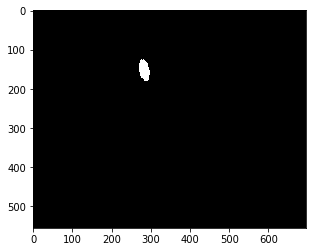

In [275]:
# plot thresholded copepod (check)

plt.imshow(thresh, cmap = 'Greys')
plt.savefig('cope_thresh_'+basename+'.png') # this will save this uniquely based on the video file basename 
# you can also choose .pdf, .jpg, etc.
plt.show() # NOTE THAT show ALWAYS HAVE OT BE AFTER savefig -- show destroys the plot

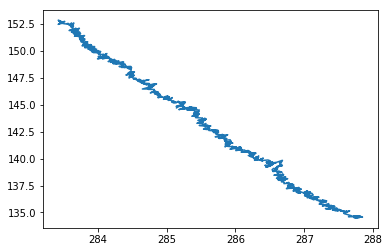

In [276]:
# plot copepod movement (check)

plt.plot(cX_list, cY_list)
plt.savefig('cope_mvmt_'+basename+'.png') # this will save this uniquely based on the video file basename

In [277]:
# normalize copepod movement to zero and format into dataframe for later use

cY_drift= [x - cY_list[0] for x in cY_list]
cX_drift= [x - cX_list[0] for x in cX_list]


cop_df = pd.DataFrame()
cop_df['y'] = cY_drift
cop_df['x'] = cX_drift

cop_df.index += 1 
cop_df.index.name = 'frame'

cop_df = cop_df[1:]

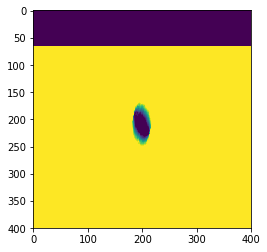

In [278]:
# look at average position (check)

cXav = cXsum / n_frames
cYav = cYsum / n_frames
background = framesum / n_frames

plt.imshow(background)
plt.savefig('avg_pos_'+basename+".png")
plt.show()

In [279]:
# find all particles in video (takes a while to run)
# this will pop up with a video finding the particles as the video plays

# read in copepod video here
cap = cv2.VideoCapture(videofilename) # uses pre-set video file name
capthresh = cv2.VideoCapture(threshvideoname) # uses pre-set video file name

# don't need to change any of the following lines
particle_size = 5 # ~average particle size in pixels
n = 1

animate = False

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret is True and n <= N:
        
        # convert to black and white
        orig = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # get copepod location
        (cX_raw2,cY_raw2,cX2,cY2,threshframe,thresh) = get_copepod_location(orig, thresh_level)
        
        # crop around copepod
        #orig = crop_frame(capthresh.read(),cX_list[0],cY_list[0],s2)
        orig = crop_frame(orig,cX_list[0],cY_list[0],s2)
        
        # subtract background (what is background???)
        frame_subtracted = orig-background
        
        # renormalize the background subtracted frame
        frame_subtracted = frame_subtracted - frame_subtracted.min()
        frame_subtracted *= (255.0/frame_subtracted.max())
        frame_subtracted = frame_subtracted.astype('uint8')

        # track particles! maybe try on the original frame
        f = tp.locate(orig, particle_size, invert=True) # replaced frame_subtracted with orig
        f['frame'] = n # add video frame number to dataframe
        if n > 1:
            ff = pd.concat([ff,f])
        else:
            ff = f
        if n%100 == 0:
            print(n)
        n += 1

        if animate:
            frame_subtracted = cv2.cvtColor(frame_subtracted, cv2.COLOR_GRAY2BGR)
            orig = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)

            for index,row in f.iterrows():
                cv2.circle(frame_subtracted,(int(row['x']),int(row['y'])),0,(0,0,255))

            anim = np.concatenate((orig,frame_subtracted), axis=1)
            anim = cv2.resize(anim,None,fx=2, fy=2, interpolation = cv2.INTER_CUBIC)

            cv2.imshow('frame',anim)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    else:
        print("finished!")
        break

cap.release()
cv2.destroyAllWindows()

100
200
300
400
500
600
700
800
900
1000
finished!


In [73]:
#skip
cap = cv2.VideoCapture(videofilename) # uses pre-set video file name
frame = cap.read()
frame = crop_frame(frame,cX_list[0],cY_list[0],s2)

IndexError: tuple index out of range

In [280]:
# link particles to create trajectories between frames (this takes a long time)
dpf = 1; # max particle displacement between frames in pixels 
t = tp.link_df(ff, dpf, memory=10) # memory: how many "dropped" frames to allow

Frame 1000: 1107 trajectories present.


In [281]:
# filter out the short particle trajectories (this takes a long time)

min_duration = 50 # [number of frames]

t1 = tp.filter_stubs(t, min_duration) # filter out trajectories of durations less than minimum 
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

('Before:', 19552)
('After:', 2983)


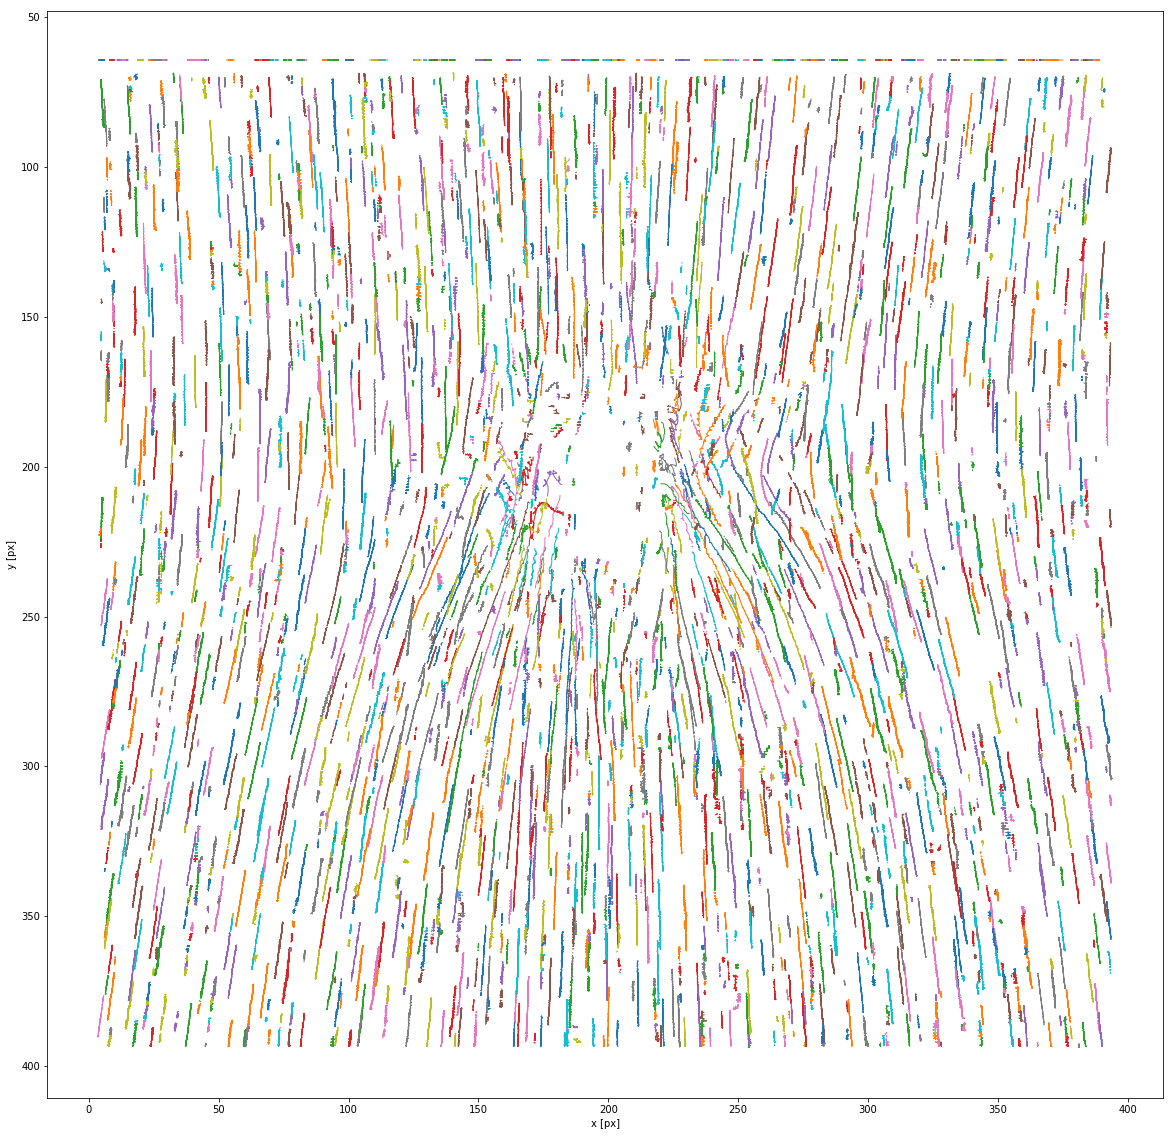

<Figure size 432x288 with 0 Axes>

In [282]:
# look at trajectories - make sure they seem reasonable (takes a while)

plt.figure(figsize=(20,20))
tp.plot_traj(t1)

plt.savefig('bgcorrect_trajectories_'+basename+'.png')

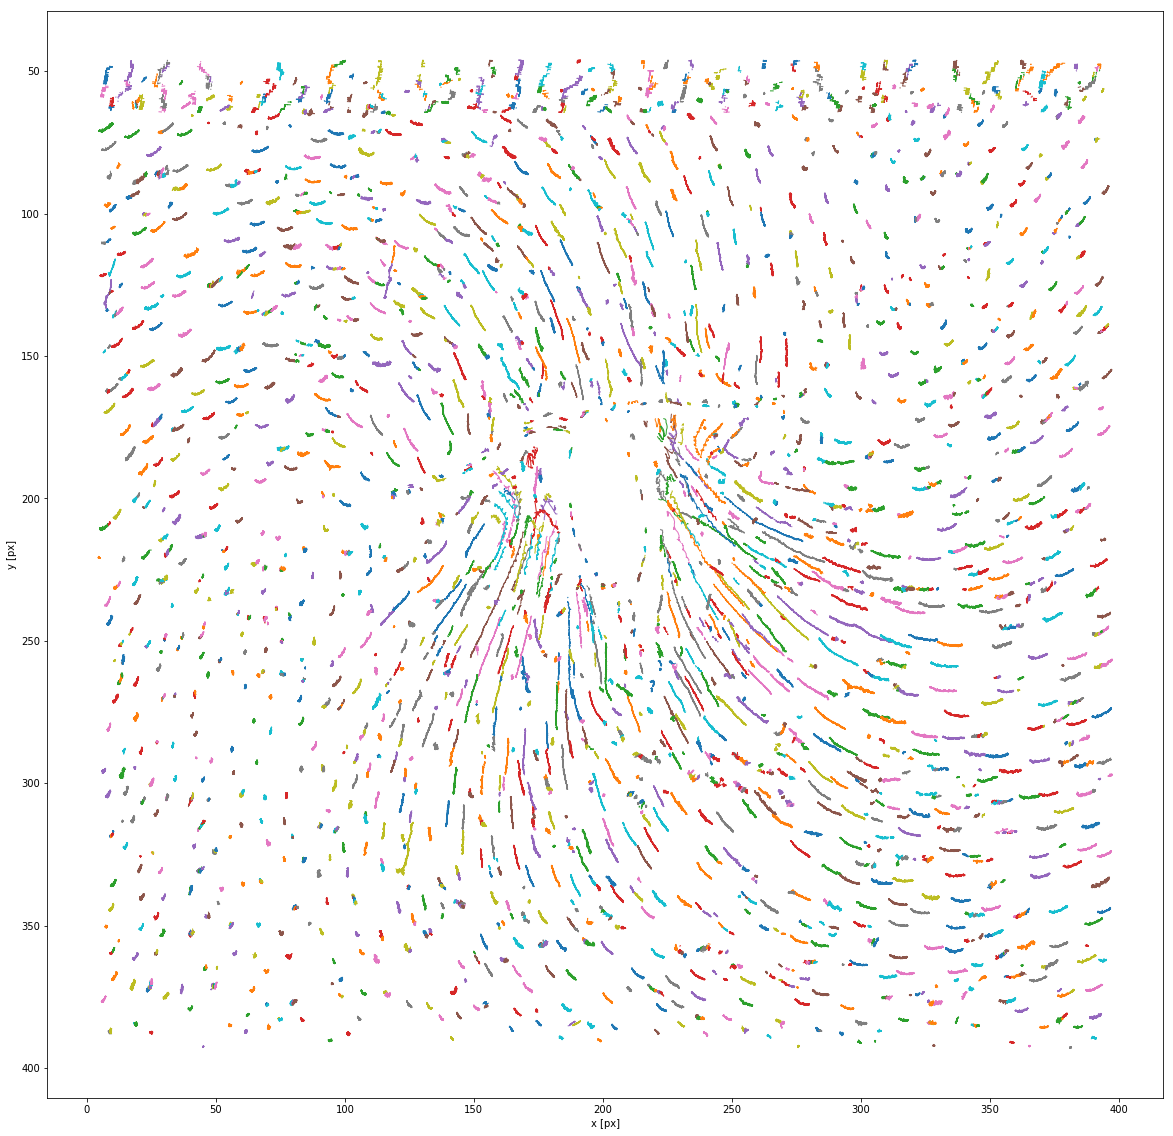

<Figure size 432x288 with 0 Axes>

In [283]:
# subtract copepod movement from particle trajectories to see particle movemet relative to the copepod
# plot new particle tracks (check that it looks reasonable)

tm = tp.subtract_drift(t1.copy(), cop_df)
plt.figure(figsize=(20,20))
ax = tp.plot_traj(tm)

plt.savefig('bgcorrect_centered_trajectories_'+basename+'.png')

In [284]:
# save all dataframes
# change file names based on video name (copy & paste video name)

# save dataframe of copepod position
cop_df.to_csv('copepod_position_'+basename+'.csv')

# save dataframe of particle positions
ff.to_csv('particle_positions_'+basename+'.csv')

# save linked positions
t.to_csv('mem10_linked_positions_'+basename+'.csv')

# save filtered trajectories
t1.to_csv('mem10_filtered_trajectories_'+basename+'.csv')

# save new particle trajectories (centered around copepod)
tm.to_csv('mem10_centered_trajectories_'+basename+'.csv') 

# if you haven't already, go back & save the two plots of the particle tracks around the copepod